 # Poincaré Embeddings for Learning Hierarchical Representations

### Abstract
Representation learning has become an invaluable approach for learning from symbolic data such as text and graphs. However, state-of-the-art embedding methods typically do not account for latent hierarchical structures which are characteristic for many complex symbolic datasets. In this work, we introduce a new approach for learning hierarchical representations of symbolic data by embedding them into hyperbolic space -- or more precisely into an n-dimensional Poincaré ball. Due to the underlying hyperbolic geometry, this allows us to learn parsimonious representations of symbolic data by simultaneously capturing hierarchy and similarity. We present an efficient algorithm to learn the embeddings based on Riemannian optimization and show experimentally that Poincaré embeddings can outperform Euclidean embeddings significantly on data with latent hierarchies, both in terms of representation capacity and in terms of generalization ability.


In [41]:
import numpy as np
import nltk
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from math import * 


#### Helper Functions

In [42]:
# plots the embedding of all the nodes of network
def plotall(ii):
    fig = plt.figure()
    # plot all the nodes
    for a in emb:
        plt.plot(emb[a][0], emb[a][1], marker = 'o', color = [levelOfNode[a]/(last_level+1),levelOfNode[a]/(last_level+1),levelOfNode[a]/(last_level+1)])
    # plot the relationship, black line means root level relationship
    # consecutive relationship lines fade out in color
    for a in network:
        for b in network[a]:
            plt.plot([emb[a][0], emb[b][0]], [emb[a][1], emb[b][1]], color = [levelOfNode[a]/(last_level+1),levelOfNode[a]/(last_level+1),levelOfNode[a]/(last_level+1)])
    # plt.show()
    fig.savefig(str(last_level) + '_' + str(ii) + '.png', dpi=fig.dpi)


In [43]:
def get_hyponyms(synset, level):
    if (level == last_level):
        levelOfNode[str(synset)] = level
        return
    # BFS
    if not str(synset) in network:
        network[str(synset)] = [str(s) for s in synset.hyponyms()]
        levelOfNode[str(synset)] = level
    for hyponym in synset.hyponyms():
        get_hyponyms(hyponym, level + 1)

![title](Distance.png)


In [44]:
# Distance in poincare disk model
def dist(vec1, vec2): # eqn1
    return 1 + 2*np.dot(vec1 - vec2, vec1 - vec2)/ \
             ((1-np.dot(vec1, vec1))*(1-np.dot(vec2, vec2)) + STABILITY)


![title](update.png)


In [45]:
# the update equation as given in the paper
def update(emb, error_): #eqn5
    try:
        update =  lr*pow((1 - np.dot(emb,emb)), 2)*error_/4
        emb = emb - update
        if (np.dot(emb, emb) >= 1):
            emb = emb/sqrt(np.dot(emb, emb)) - STABILITY
        return emb
    except Exception as e:    # Testing
        print (e)

Init Embedding


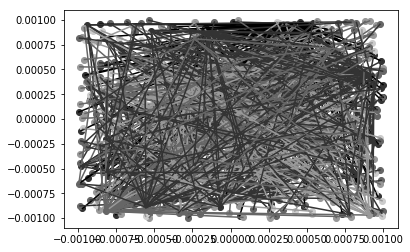

In [46]:
import random
# network: the actual network of which node is connected to whom
# levelOfNode: level of the node in hierarchical data
levelOfNode = {}
last_level = 4
network = {} # representation of network (here it is hierarchical)

# recursive function to popoulate the hyponyms of a root node in `network`
# synset: the root node
# last_level: the level till which we consider the hyponyms
bird = wordnet.synset('tree.n.01')
get_hyponyms(bird, 0)
levelOfNode[str(bird)] = 0
bird = wordnet.synset('tree.n.01')
get_hyponyms(bird, 0)
levelOfNode[str(bird)] = 0

# embedding of nodes of network
emb = {}

# Randomly uniform distribution
for a in network:
    for b in network[a]:
        emb[b] = np.random.uniform(low=-0.001, high=0.001, size=(2,))
    emb[a] = np.random.uniform(low=-0.001, high=0.001, size=(2,))

vocab = list(emb.keys())
random.shuffle(vocab)

# the leave nodes are not connected to anything
for a in emb:
    if not a in network:
        network[a] = []

lr = 0.01
num_negs = 5

# The plot of initialized embeddings
plotall("init")
print("Init Embedding")

#### Proj
![title](proj.png)


#### The partial derivate of the Poincaré distance with respect to θ is then given as
![title](formula.png)   


#### Update Embedding 
## ∇E = ( ∂L(θ)/∂d(θ,x) ) * ( ∂d(θ,x)/∂d(θ) )

In [47]:
# Partial derivative as given in the paper wrt theta
def partial_der(theta, x, gamma): #eqn4
    alpha = (1.0-np.dot(theta, theta))
    norm_x = np.dot(x, x)
    beta = (1-norm_x)
    gamma = gamma
#     print("Alpha:",alpha)
#     print("Beta:",beta)
#     print("Gamma:",gamma)
#     print("Theta:",theta)
#     print("X:",x)
    return 4.0/(beta * sqrt(gamma*gamma - 1) + STABILITY)*((norm_x- 2*np.dot(theta, x)+1)/(pow(alpha,2)+STABILITY)*theta - x/(alpha + STABILITY))


Epoch : 0
Epoch : 50
Epoch : 100
Epoch : 150
Epoch : 200
Epoch : 250
Epoch : 300
Epoch : 350
Epoch : 400
Epoch : 450


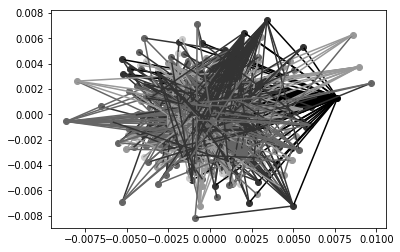

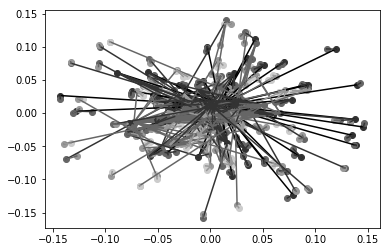

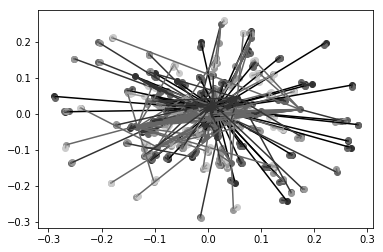

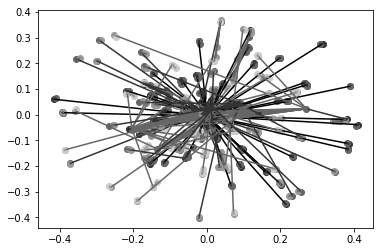

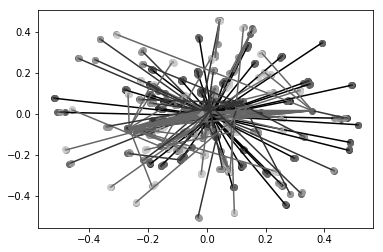

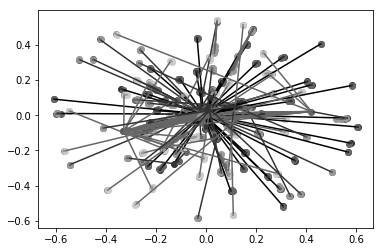

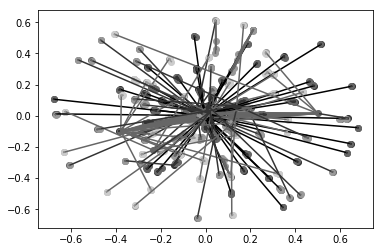

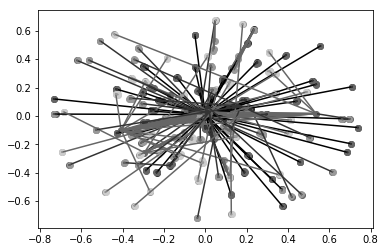

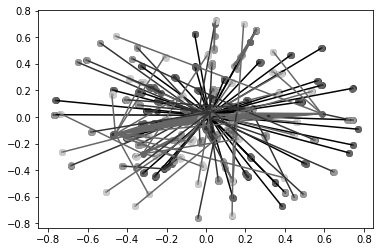

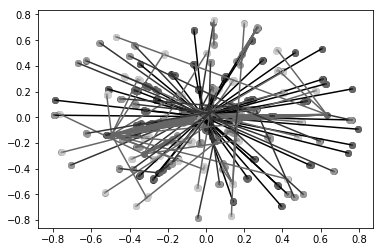

In [48]:
STABILITY = 0.00001 # to avoid overflow while dividing

for epoch in range(500):
    # pos2 is related to pos1
    # negs are not related to pos1
    for pos1 in vocab:
        if not network[pos1]: # a leaf node
            continue
        pos2 = random.choice(network[pos1]) # pos2 and pos1 are related
        dist_p_init = dist(emb[pos1], emb[pos2]) # distance between the related nodes
        if (dist_p_init > 700): # this causes overflow
            print ("got one very high") 
            dist_p_init = 700
        elif (dist_p_init < -700):
            print ("got one very high")
            dist_p_init = -700
        dist_p = cosh(dist_p_init) # this is the actual distance
        # print ("distance between related nodes", dist_p)
        negs = [] # pairs of not related nodes, the first node in the pair is `pos1`
        dist_negs_init = [] # distances without taking cosh on it (for not related nodes)
        dist_negs = [] # distances with taking cosh on it (for not related nodes)
        while (len(negs) < num_negs):
            neg1 = pos1
            neg2 = random.choice(vocab)
            if not (neg2 in network[neg1] or neg1 in network[neg2] or neg2 == neg1): # neg2 should not be related to neg1 and vice versa
                dist_neg_init = dist(emb[neg1], emb[neg2])
                if (dist_neg_init > 700 or dist_neg_init < -700): # already dist is good, leave it
                    continue
                negs.append([neg1, neg2])
                dist_neg = cosh(dist_neg_init)
                dist_negs_init.append(dist_neg_init) 
                dist_negs.append(dist_neg)
                # print ("distance between non related nodes", dist_neg)
        loss_den = 0.0
        # eqn6
        for dist_neg in dist_negs:
            loss_den += exp(-1*dist_neg) # Sigmoid Function 
        loss = -1*dist_p - log(loss_den + STABILITY) 
        # derivative of loss wrt positive relation [d(u, v)]
        der_p = -1
        der_negs = []
        # derivative of loss wrt negative relation [d(u, v')]
        for dist_neg in dist_negs:
            der_negs.append(exp(-1*dist_neg)/(loss_den + STABILITY))
        # derivative of loss wrt pos1
        der_p_pos1 = der_p * partial_der(emb[pos1], emb[pos2], dist_p_init)
        # derivative of loss wrt pos2
        der_p_pos2 = der_p * partial_der(emb[pos2], emb[pos1], dist_p_init)
        der_negs_final = []
        for (der_neg, neg, dist_neg_init) in zip(der_negs, negs, dist_negs_init):
            # derivative of loss wrt second element of the pair in neg
            der_neg1 = der_neg * partial_der(emb[neg[1]], emb[neg[0]], dist_neg_init)
            # derivative of loss wrt first element of the pair in neg
            der_neg0 = der_neg * partial_der(emb[neg[0]], emb[neg[1]], dist_neg_init)
            der_negs_final.append([der_neg0, der_neg1])
        # update embeddings now
        emb[pos1] = update(emb[pos1], -1*der_p_pos1)
        emb[pos2] = update(emb[pos2], -1*der_p_pos2)
        for (neg, der_neg) in zip(negs, der_negs_final):
            emb[neg[0]] = update(emb[neg[0]], -1*der_neg[0])
            emb[neg[1]] = update(emb[neg[1]], -1*der_neg[1])
    # plot the embeddings
    if ((epoch)%50 == 0):
        print("Epoch :",epoch)
        plotall(epoch)

### References 
-  Poincaré Embeddings for Learning Hierarchical Representations | https://arxiv.org/abs/1705.08039
- Poincaré Conjecture - Numberphile | https://www.youtube.com/watch?v=GItmC9lxeco
- Hyperbolic space | https://en.wikipedia.org/wiki/Hyperbolic_space
- Poincaré disk model | https://en.wikipedia.org/wiki/Hyperbolic_tree
